In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ssl
import certifi
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
test_file = 'nlp-getting-started/test.csv'
train_file = 'nlp-getting-started/train.csv'
test_data = pd.read_csv(test_file)
train_data = pd.read_csv(train_file)

### Part A

In [3]:
num_train = train_data.shape[0]
num_test = test_data.shape[0]

print(f'Number of training data points: {num_train}')
print(f'Number of test data points: {num_test}')

real_disaster_count = train_data[train_data['target'] == 1].shape[0]
non_disaster_count = train_data[train_data['target'] == 0].shape[0]

real_disaster_percentage = (real_disaster_count / num_train) * 100
non_disaster_percentage = (non_disaster_count / num_train) * 100

print(f'Percentage of real disasters in training data: {real_disaster_percentage:.2f}%')
print(f'Percentage of non-disasters in training data: {non_disaster_percentage:.2f}%')

Number of training data points: 7613
Number of test data points: 3263
Percentage of real disasters in training data: 42.97%
Percentage of non-disasters in training data: 57.03%


### Part B

In [4]:
from sklearn.model_selection import train_test_split

# ensures that the distribution of the target column (i.e., real vs. non-disaster tweets) 
# is similar in both the training and development sets.
train_set, dev_set = train_test_split(train_data, test_size=0.3, random_state=42, stratify=train_data['target'])

print(f'Number of training data points: {train_set.shape[0]}')
print(f'Number of development data points: {dev_set.shape[0]}')

y_train = train_set['target']
y_dev = dev_set['target']

print(y_train.value_counts(normalize=True))
print(y_dev.value_counts(normalize=True))

Number of training data points: 5329
Number of development data points: 2284
target
0    0.570276
1    0.429724
Name: proportion, dtype: float64
target
0    0.57049
1    0.42951
Name: proportion, dtype: float64


### Part C

In [5]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to preprocess text
def preprocess_tweet(text):
    # 1. Convert all words to lowercase
    text = text.lower()
    
    # 2. Lemmatize all the words
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    
    # 3. Strip punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # 4. Strip stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    # 5. Strip @ mentions and URLs
    text = re.sub(r'@\w+|http\S+', '', text)
    
    return text

train_set['processed_text'] = train_set['text'].apply(preprocess_tweet)
dev_set['processed_text'] = dev_set['text'].apply(preprocess_tweet)

# Show the first few processed tweets
train_set[['text', 'processed_text']].head()
dev_set[['text', 'processed_text']].head()

,text,processed_text
1431,Was '80s New #Wave a #Casualty of #AIDS?: Twee...,wa 80s new wave casualty aids tweet since they...
5726,http://t.co/XlFi7ovhFJ VIDEO: 'We're picking u...,video picking body water rescuer searching hu...
6153,Don't argue cheap now. You're better than that...,dont argue cheap youre better
5962,@Scalpium SCREAMING,scalpium screaming
7558,coleslaw #wrecked http://t.co/sijNBmCZIJ,coleslaw wrecked


### Part D

#### Discovering Appropriate M

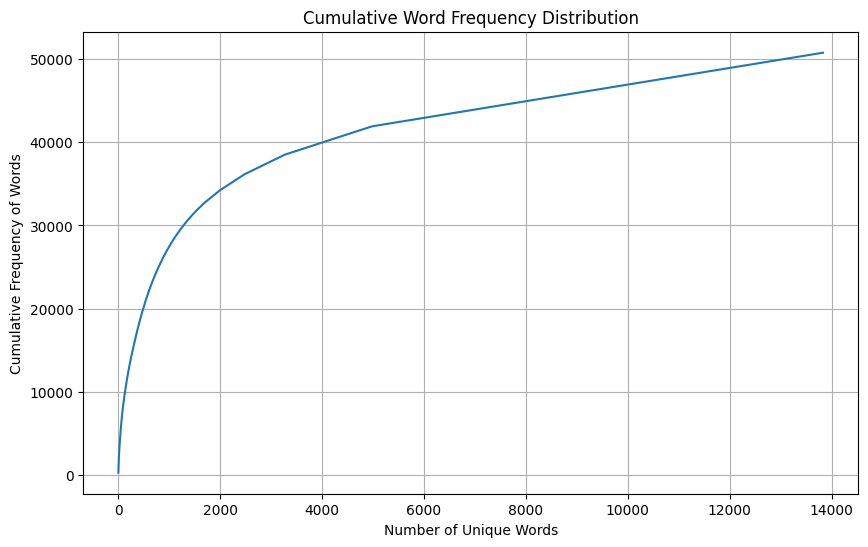

50th percentile: Words that appear at least 1 times cover 50% of the vocabulary.
75th percentile: Words that appear at least 2 times cover 75% of the vocabulary.
90th percentile: Words that appear at least 7 times cover 90% of the vocabulary.
95th percentile: Words that appear at least 15 times cover 95% of the vocabulary.
99th percentile: Words that appear at least 41 times cover 99% of the vocabulary.


In [6]:
from collections import Counter

# Tokenize the words in the training set's 'text' column (replace 'text' with 'processed_text' if available)
word_counts = Counter(" ".join(train_set['processed_text']).split())

# Get the total number of unique words and their frequencies
word_frequencies = np.array(list(word_counts.values()))

# Sort frequencies in ascending order
sorted_frequencies = np.sort(word_frequencies)

# Calculate cumulative sum of words appearing at least x times
cumulative_frequencies = np.cumsum(sorted_frequencies[::-1])

# Plot cumulative distribution to analyze where most words appear
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(cumulative_frequencies) + 1), cumulative_frequencies)
plt.title('Cumulative Word Frequency Distribution')
plt.xlabel('Number of Unique Words')
plt.ylabel('Cumulative Frequency of Words')
plt.grid(True)
plt.show()

# Print summary statistics for threshold selection
percentiles = [50, 75, 90, 95, 99]
for p in percentiles:
    threshold = np.percentile(sorted_frequencies, p)
    print(f"{p}th percentile: Words that appear at least {int(threshold)} times cover {p}% of the vocabulary.")

#### Bag Of Words

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

M = 5

vectorizer = CountVectorizer(binary=True, min_df=M)

# Fit the vectorizer on the training data (only on the 'processed_text' column)
vectorizer.fit(train_set['processed_text'])

# Transform the training and development sets into bag of words vectors
X_train = vectorizer.transform(train_set['processed_text'])
X_dev = vectorizer.transform(dev_set['processed_text'])

print(f'Total number of features in the BoW vectors: {X_train.shape[1]}')

Total number of features in the BoW vectors: 1944


### Part E

#### Part E.I | Logistic regression model without regularization terms.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

log_reg_no_reg = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000)
log_reg_no_reg.fit(X_train, y_train)

y_train_pred = log_reg_no_reg.predict(X_train)
y_dev_pred = log_reg_no_reg.predict(X_dev)

f1_train = f1_score(y_train, y_train_pred)
f1_dev = f1_score(y_dev, y_dev_pred)

print(f"F1 Score on Training Set: {f1_train:.4f}")
print(f"F1 Score on Development Set: {f1_dev:.4f}")

F1 Score on Training Set: 0.9689
F1 Score on Development Set: 0.6940


#### Part E.II | Logistic regression model with L1 regularization term.

In [9]:
log_reg_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

log_reg_l1.fit(X_train, y_train)

y_train_pred_l1 = log_reg_l1.predict(X_train)
y_dev_pred_l1 = log_reg_l1.predict(X_dev)

f1_train_l1 = f1_score(y_train, y_train_pred_l1)
f1_dev_l1 = f1_score(y_dev, y_dev_pred_l1)

print(f"F1 Score on Training Set (L1 Regularization): {f1_train_l1:.4f}")
print(f"F1 Score on Development Set (L1 Regularization): {f1_dev_l1:.4f}")

F1 Score on Training Set (L1 Regularization): 0.8446
F1 Score on Development Set (L1 Regularization): 0.7500


#### Part E.III | Logistic regression model with L2 regularization term.

In [10]:
log_reg_l2 = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000)

log_reg_l2.fit(X_train, y_train)

y_train_pred_l2 = log_reg_l2.predict(X_train)
y_dev_pred_l2 = log_reg_l2.predict(X_dev)

f1_train_l2 = f1_score(y_train, y_train_pred_l2)
f1_dev_l2 = f1_score(y_dev, y_dev_pred_l2)

print(f"F1 Score on Training Set (L2 Regularization): {f1_train_l2:.4f}")
print(f"F1 Score on Development Set (L2 Regularization): {f1_dev_l2:.4f}")

F1 Score on Training Set (L2 Regularization): 0.8631
F1 Score on Development Set (L2 Regularization): 0.7549


#### Part E.V | Most important words

In [11]:
coef_l1 = log_reg_l1.coef_[0] 

feature_names = vectorizer.get_feature_names_out()

word_weights = list(zip(feature_names, coef_l1))

important_words = sorted(word_weights, key=lambda x: abs(x[1]), reverse=True)

print("Top 10 most important words for deciding whether a tweet is about a real disaster or not:")
for word, weight in important_words[:10]:
    print(f"{word}: {weight:.4f}")

Top 10 most important words for deciding whether a tweet is about a real disaster or not:
spill: 4.1322
airport: 3.6131
hiroshima: 3.2936
typhoon: 3.1624
outbreak: 3.0993
debris: 2.7610
earthquake: 2.6958
derailment: 2.5837
wildfire: 2.5785
bomber: 2.5704


### Part F

In [13]:
import numpy as np

class BernoulliNaiveBayes:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = None
        self.likelihoods = None
        self.classes = None

    def fit(self, X, y):
        """ Fit the Bernoulli Naive Bayes model using Laplace smoothing. """
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)

        self.class_priors = np.zeros(n_classes)
        self.likelihoods = np.zeros((n_classes, n_features))

        for idx, c in enumerate(self.classes):
            X_c = X[y == c]
            self.class_priors[idx] = X_c.shape[0] / float(n_samples)
            self.likelihoods[idx, :] = (np.sum(X_c, axis=0) + self.alpha) / (X_c.shape[0] + 2 * self.alpha)

    def predict(self, X):
        """ Predict the class labels for input X. """
        if hasattr(X, "toarray"):
            X = X.toarray()
    
        n_samples = X.shape[0]
        n_classes = len(self.classes)
        log_prob = np.zeros((n_samples, n_classes))
    
        for idx, c in enumerate(self.classes):
            # Calculate log likelihood and log prior
            log_likelihood = X * np.log(self.likelihoods[idx, :]) + (1 - X) * np.log(1 - self.likelihoods[idx, :])
            log_prob[:, idx] = np.sum(log_likelihood, axis=1) + np.log(self.class_priors[idx])
    
        return self.classes[np.argmax(log_prob, axis=1)]

    def predict_proba(self, X):
        """ Predict the probability of each class. """
        n_samples = X.shape[0]
        n_classes = len(self.classes)
        log_prob = np.zeros((n_samples, n_classes))

        for idx, c in enumerate(self.classes):
            log_likelihood = X * np.log(self.likelihoods[idx, :]) + (1 - X) * np.log(1 - self.likelihoods[idx, :])
            log_prob[:, idx] = np.sum(log_likelihood, axis=1) + np.log(self.class_priors[idx])

        prob = np.exp(log_prob)
        return prob / np.sum(prob, axis=1, keepdims=True)

bnb = BernoulliNaiveBayes(alpha=1.0)
bnb.fit(X_train, y_train)

y_pred = bnb.predict(X_dev)

f1 = f1_score(y_dev, y_pred)
print(f"F1 Score on Development Set: {f1:.4f}")

F1 Score on Development Set: 0.7500


### Part H

#### N-gram model

In [54]:
from sklearn.feature_extraction.text import CountVectorizer

M = 5
vectorizer = CountVectorizer(ngram_range=(2, 2), min_df=M)

X_train_ngrams = vectorizer.fit_transform(train_set['processed_text'])
X_dev_ngrams = vectorizer.transform(dev_set['processed_text'])

vocabulary = vectorizer.get_feature_names_out()

print(f"Total number of 2-grams in vocabulary: {len(vocabulary)}")

# Print out 10 random 2-grams from the vocabulary
import random
random_ngrams = random.sample(list(vocabulary), 10)
print("10 random 2-grams from the vocabulary:", random_ngrams)

Total number of 2-grams in vocabulary: 601
10 random 2-grams from the vocabulary: ['suspect dead', 'germ wake', 'suspect killed', 'past anniversary', 'cree led', 'cant wait', 'apollo brown', 'chinas stock', 'fukushima nuclear', 'nuclear disaster']


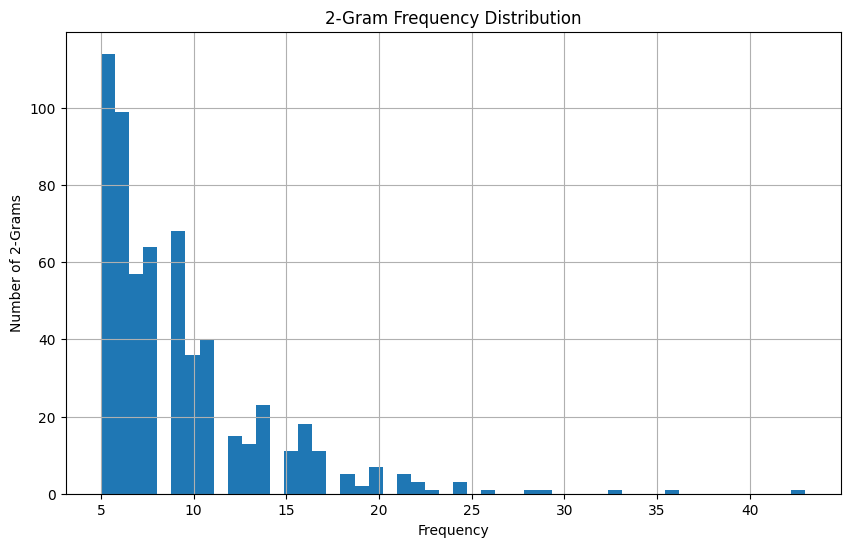

In [55]:
# Get the frequency of each 2-gram
ngram_frequencies = np.asarray(X_train_ngrams.sum(axis=0)).ravel()

# Plot a histogram of 2-gram frequencies
plt.figure(figsize=(10, 6))
plt.hist(ngram_frequencies, bins=50)
plt.title('2-Gram Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Number of 2-Grams')
plt.grid(True)
plt.show()

# You can then choose an appropriate value for M based on the plot.

#### Logistic regression with N-gram

In [58]:
# Train logistic regression with L2 regularization (or adjust based on results from previous tasks)
log_reg_2grams = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000)
log_reg_2grams.fit(X_train_ngrams, y_train)

# Predict on training and development sets
y_train_pred = log_reg_2grams.predict(X_train_ngrams)
y_dev_pred = log_reg_2grams.predict(X_dev_ngrams)

# Calculate F1-scores
f1_train_lr = f1_score(y_train, y_train_pred)
f1_dev_lr = f1_score(y_dev, y_dev_pred)

print(f"F1 Score on Training Set (Logistic Regression with 2-grams): {f1_train_lr:.4f}")
print(f"F1 Score on Development Set (Logistic Regression with 2-grams): {f1_dev_lr:.4f}")

F1 Score on Training Set (Logistic Regression with 2-grams): 0.5302
F1 Score on Development Set (Logistic Regression with 2-grams): 0.5171


#### Bernoulli Naive Bayes with N-gram

In [59]:
from sklearn.naive_bayes import BernoulliNB

bnb_2grams = BernoulliNB()
bnb_2grams.fit(X_train_ngrams, y_train)

y_train_pred_bnb = bnb_2grams.predict(X_train_ngrams)
y_dev_pred_bnb = bnb_2grams.predict(X_dev_ngrams)

f1_train_bnb = f1_score(y_train, y_train_pred_bnb)
f1_dev_bnb = f1_score(y_dev, y_dev_pred_bnb)

print(f"F1 Score on Training Set (Bernoulli Naive Bayes with 2-grams): {f1_train_bnb:.4f}")
print(f"F1 Score on Development Set (Bernoulli Naive Bayes with 2-grams): {f1_dev_bnb:.4f}")

F1 Score on Training Set (Bernoulli Naive Bayes with 2-grams): 0.4838
F1 Score on Development Set (Bernoulli Naive Bayes with 2-grams): 0.4832


### Part I

In [61]:
full_train_set = pd.concat([train_set, dev_set])

vectorizer = CountVectorizer(min_df=5) 
X_full_train = vectorizer.fit_transform(full_train_set['processed_text'])

y_full_train = full_train_set['target']

In [68]:
test_data['processed_text'] = test_data['text'].apply(preprocess_tweet) 
X_test = vectorizer.transform(test_data['processed_text'])

In [69]:
# Train logistic regression on the full training data
log_reg_full = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000)
log_reg_full.fit(X_full_train, y_full_train)

LogisticRegression(max_iter=1000)

In [70]:
y_test_pred = log_reg_full.predict(X_test) 

In [72]:

submission = pd.DataFrame({
    'id': test_data['id'],
    'target': y_test_pred})


submission.to_csv('submission.csv', index=False)